## Introduction

This notebook constructs a neural network that is meant to represent a thermodynamic model. This network has the following architecture: The input layer represents sequences. Different parts of the input sequences are fed to different nodes in the first hidden layer, e.g. consider sequences that contain binding sites for two transcription factors (e.g. CRP and RNAP), then the subsequence representing one binding site will be fed-forward to one node and the subsequence represent the other binding site will be fed to another node. The weights connected to each of these nodes may be interpreted as the position weight matrices of their respective transcription factors and the values of the two nodes in the first hidden layers represent binding energies of each of these proteins. This layer follows a fully connected layer but with binary weights; these weights are frozen during training because they represent microstates of the thermodynamic model; this layer is softmax activated. The softmax layer is fed a second input layer which is meant to represent the interaction gamma between CRP and RNAP. This softmax layer feeds into one node for the output, which represents the transcription rate. Every activation except the softmax is linear. 

### Architecture Diagram
<img src="gamma_model.png" alt="drawing" style="width:450px;height:275px;"/>

### Notes

- The CRP motif is almost always learned. The RNAP motif often does not get learned. I have to initialize the weights like the values from the RNAP df from the 2010 sort-seq paper, and only then did the network learn the RNAP motif. Sub-note: SGD seems to work a lot better than ADAM in finding both motifs. I'll stick to SGD.

- For the interaction term gamma, an intermediate input is injected into the softmax layer of value 1. This one gets split into four nodes of the softmax layer, but the weights are fixed to [0,0,0,1], meaning that the gamma term only contributes to the fourth microstate (in which both crp and rnap are bound). 



#### TO DO

- ~~Need to write custom last layer with first two connections zero and last two weights tied~~
- ~~check the number of parameters in the first hidden layer matches the shapes of the PWMs.~~
- ~~Make distributions of intermediate layer activations for differnet sequences.~~
- check if energy and transcriptions input values are reasonable. Need to run this by Justin
- ~~Try other optimizers (e.g. SGD, RMSProp) check if RNAP motif is learned with random initial values for RNAP_pwm layer~~
- ~~implemented callback~~ use as: tensorboard --logdir ./Graph

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Input, Concatenate, Lambda
from keras.optimizers import Adam, SGD
import keras.backend as K
import keras
from keras.callbacks import EarlyStopping
from keras.constraints import nonneg

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import random

Using TensorFlow backend.


## Curate simulated data

### load position weight matrices for RNAP and CRP

In [2]:
# Load the energy matrices from Kinney et al. 2010
crp_df = pd.read_csv('data/energy_matrices/crp_tau_final_all.26.txt', sep = "\t", usecols = range(1,5))
#rnap_df = pd.read_csv('data/energy_matrices/rnap_tau_final_all.41.txt', sep = "\t", usecols = range(1,5))
rnap_df = pd.read_csv('data/energy_matrices/rnap_tau_final_all.41_supplement.txt', sep = "\t", usecols = range(1,5))

# Convert the dataframe to numpy array for downstream processing
crp_array = pd.DataFrame.to_numpy(crp_df)
rnap_array = pd.DataFrame.to_numpy(rnap_df)

### set parameters

In [3]:
# Set up parameters
gaps = 7 # Length of gaps between CRP and RNAP binding sites
c_r = 5.94e-3 # Concentration of RNAP; Empirically determined
c_c = 10 ** -1.2 # Concentration of active CRP
e_i = -3.26 # Energy of interaction
t_bg = 0.01 # Background noise
consensus_sequence = "AATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG"
crp_wt_sequence = consensus_sequence[1:27]
rnap_wt_seq = "CAGGCTTTACACCTGTTGCCTCCGGCTCGTATGTTGTGTGG"
crp_wt_energy = 6.9 # From Kinney et al. 2010
rnap_wt_energy = 8.3 # From Kinney et al. 2010

### Helper functions

In [4]:
def mutate_sequence(con_seq, mut_rate):
    bases = ["A","C","G","T"]
    new_seq = list(con_seq)
    to_mutate = np.random.random(size = len(con_seq)) < mut_rate
    for i in range(0,len(to_mutate)):
        if to_mutate[i]:
            new_seq[i] = random.choice([b for b in bases if b not in new_seq[i]])
    return ''.join(new_seq)

# Fit a label encoder and a onehot encoder
bases = ["A","C","G","T"]
label_encoder = LabelEncoder()
label_encoder.fit(bases)
tmp = label_encoder.transform(bases)
tmp = tmp.reshape(len(tmp), 1)
onehot_encoder = OneHotEncoder(sparse = False)
onehot_encoder.fit(tmp)

# Encode sequence into onehot
def onehot_sequence(sequence, lab_encoder = label_encoder, one_encoder = onehot_encoder):
    """Sequence as a string"""
    tmp = lab_encoder.transform(list(sequence))
    tmp = tmp.reshape(len(tmp),1)
    tmp = one_encoder.transform(tmp)
    return tmp

# Calculate energy
def get_energy(seq_onehot, matrix_array):
    return np.sum(matrix_array * seq_onehot)

# # Calculate boltzmann weight
# def get_transcription(e_r, e_c, e_i = -3.26, c_r = 5.94e-3, c_c = 10 ** -1.2):
#     #const = 1.98e-3 * 310
#     RT = 1.0
#     tau_max = 1.0
#     tmp1 = c_r*np.exp(-e_r/RT) + c_c*c_r*np.exp(-(e_c+e_r+e_i)/RT)
#     tmp2 = 1 + c_c*np.exp(-e_c/RT) + c_r*np.exp(-e_r/RT) + c_c*c_r*np.exp(-(e_c+e_r+e_i)/RT)
#     return tau_max*(tmp1/tmp2)

# get transcription with chemical potentials
#def get_transcription(e_r, e_c, e_i = -3.26, mu_r = 2.7, mu_c = 3):
def get_transcription(e_r, e_c, e_i = -3.26, mu_r = 2.7, mu_c = 3):
    
    # the following method sets RT = 1.0, so everything is in thermal units.
    tau_max = 1.00
    tmp1 = c_r*np.exp(-(e_r-mu_r)) + np.exp(-(e_c+e_r+e_i-mu_r-mu_c))
    tmp2 = 1 + c_c*np.exp(-(e_c-mu_c)) + np.exp(-(e_r-mu_r)) + np.exp(-(e_c+e_r+e_i-mu_c-mu_r))
    return tau_max*(tmp1/tmp2)

def reverse_complement(seq):
    complement = str.maketrans('ATCGN', 'TAGCN')
    return str(seq).upper().translate(complement)[::-1]

In [5]:
def generate_mutant_seqs_and_their_transcription_rates(crp_wt_seq = crp_wt_sequence,rnap_wt_seq = rnap_wt_seq, mutrate = 0.1):
    """
    helper function which generates simulated data; data consists of mutant sequences and their 
    associated transcription rates.
    """

    #next_sequence = mutate_sequence(wt_seq,mutrate)
    
    crp_sequence = crp_wt_seq
    next_crp_sequence = mutate_sequence(crp_sequence,mutrate)
    
    rnap_sequence =rnap_wt_seq
    next_rnap_sequence = mutate_sequence(rnap_sequence,mutrate)
    
    ec = get_energy(onehot_sequence(next_crp_sequence),crp_array)
    er = get_energy(onehot_sequence(next_rnap_sequence),rnap_array)
    
    # mutated input sequence
    next_sequence =  next_crp_sequence+next_rnap_sequence               
    tau = get_transcription(er,ec)
    
    return next_sequence, tau, ec, er

input_sequences = [] 
labels = []

# lists containing binding energies for each protein
e_c_list = []
e_r_list = []

test_input_sequences = []
test_labels = []

training_data_size = 20000
test_data_size = 2000

for _ in range(training_data_size):
    
    if _ < training_data_size-test_data_size:
        
        temp_seq, temp_tau, temp_ec, temp_er = generate_mutant_seqs_and_their_transcription_rates()
        #temp_seq, temp_tau = generate_mutant_seqs_and_their_transcription_rates_rc()
        input_sequences.append(temp_seq)
        labels.append(temp_tau)
        e_c_list.append(temp_ec)
        e_r_list.append(temp_er)
    
    else:        
        
        temp_seq, temp_tau, temp_ec, temp_er = generate_mutant_seqs_and_their_transcription_rates()
        #temp_seq, temp_tau = generate_mutant_seqs_and_their_transcription_rates_rc()
        test_input_sequences.append(temp_seq)
        test_labels.append(temp_tau)
        e_c_list.append(temp_ec)
        e_r_list.append(temp_er)     

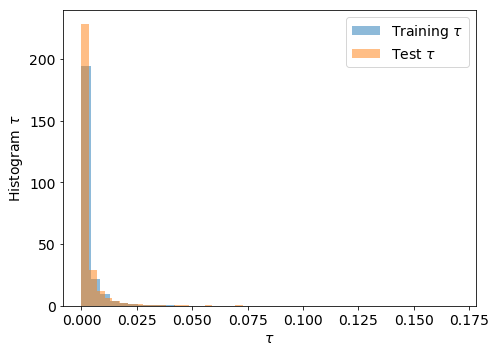

In [6]:
plt.figure(figsize=(7,5))
plt.hist(labels,bins=40,alpha=0.5,label='Training '+ r'$\tau$',density=True)
plt.hist(test_labels,bins=40,alpha=0.5,density=True,label='Test '+ r'$\tau$')
plt.legend(fontsize=14)
plt.tick_params(labelsize=14)
plt.ylabel('Histogram '+r'$\tau$',fontsize=14)
plt.xlabel(r'$\tau$',fontsize=14)
plt.tight_layout()
#plt.savefig('input_data.png')
plt.show()

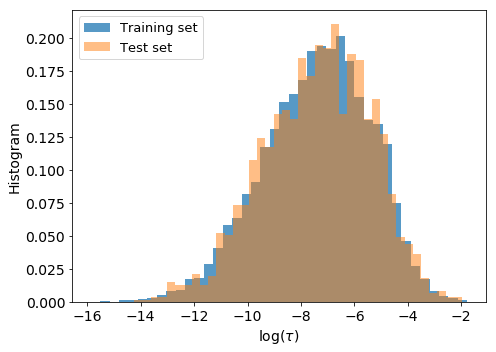

In [7]:
plt.figure(figsize=(7,5))
plt.hist(np.log(labels),bins=40,alpha=0.75,density=True,label='Training set')
plt.hist(np.log(test_labels),bins=40,alpha=0.5,density=True,label='Test set')
plt.legend(fontsize=13)
plt.xlabel('log('+r'$\tau$)',fontsize=14)
plt.ylabel('Histogram',fontsize=14)
plt.tick_params(labelsize=14)
plt.tight_layout()
#plt.savefig('../write_up/write_up_for_rnap_neural_network/log_tau_hist.png')
plt.show()

### Specify custom layer for last layer weights

In [8]:
import tensorflow as tf
from keras.layers import multiply

class CustomConnected(Dense):

    def __init__(self,units,connections, output_dim,**kwargs):
        
        self.output_dim = output_dim
        #this is matrix of connections. I.e., this should be [0,0,trainable,trainable]
        self.connections = connections                        
        #initalize the original Dense with all the usual arguments   
        super(CustomConnected,self).__init__(units,**kwargs)  


    def call(self, inputs):
        #print(self.connections)
        
        kernel_times_connections = multiply([self.kernel, self.connections])
        #output = K.dot(inputs, self.kernel * self.connections)
        output = K.dot(inputs,kernel_times_connections)

        #print('outputs: ',output)
        #print('inputs: ',inputs)
        #print('kernel',self.kernel)
        
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    
        

## Neural Network Model (CRP - RNAP)

In [9]:
number_input_layer_nodes = len(test_input_sequences[0])*4    
inputTensor = Input((number_input_layer_nodes,),name='Sequence')

In [10]:
# define two groups which represent binding sites for the two proteins crp and rnap

group1 = Lambda(lambda x: x[:,0:104], output_shape=((104,)))(inputTensor)
group2 = Lambda(lambda x: x[:,104:268], output_shape=((164,)))(inputTensor)


# From input to first hidden layer. The groups are connected to two nodes
# node group1 represents energy of crp and group2 represents rnap energy.

# rename group1 to crp pwm

group1 = Dense(1,use_bias=False,name='CRP_pwm')(group1)
group2 = Dense(1,use_bias=False,name='RNAP_pwm',kernel_initializer='RandomNormal')(group2)
#group2 = Dense(1,use_bias=False,name='RNAP_pwm',kernel_initializer='RandomNormal',W_constraint=nonneg())(group2)

# the groups from the previous layer have to be concatenated so
concatenateLayer = Concatenate()([group1,group2])

gammaInput = Input(shape=(1,),name='gamma_Input')   # i.e. weights going into softmax: [0,0,0,1]
concatenateLayer_with_gamma = Concatenate()([group1,group2,gammaInput])


# softmax layer needs to have multiple inputs

softmaxLayer = Dense(4,activation='softmax', trainable=False, use_bias=False,name='softmax_layer')(concatenateLayer_with_gamma)



# output the softmax layer to a single node
# outputTensor = Dense(1,activation='linear',use_bias=False)(softmaxLayer)
#outputTensor = CustomConnected(1,tf.constant([0.0,0.0,1.0,1.0]),1,use_bias=False,name='custom_tao_layer')(softmaxLayer)
outputTensor = CustomConnected(1,tf.constant([0.0,0.0,1.0,1.0]),1,use_bias=False,name='custom_tau_layer')(softmaxLayer)

#create the model:
# model = Model(inputTensor,outputTensor)
model = Model(inputs=[inputTensor, gammaInput], outputs=outputTensor)

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence (InputLayer)           (None, 268)          0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 104)          0           Sequence[0][0]                   
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 164)          0           Sequence[0][0]                   
__________________________________________________________________________________________________
CRP_pwm (Dense)                 (None, 1)            104         lambda_1[0][0]                   
__________________________________________________________________________________________________
RNAP_pwm (

In [12]:
model.layers

In [13]:
model.layers[7].get_weights()[0]

array([[-0.8423686 , -0.848395  , -0.15158796, -0.7449981 ],
       [ 0.90150726, -0.13927525,  0.9247401 , -0.57766235],
       [-0.6988581 , -0.9007144 ,  0.576939  , -0.7016711 ]],
      dtype=float32)

In [14]:
outputTensor

<tf.Tensor 'custom_tau_layer/MatMul:0' shape=(?, 1) dtype=float32>

#### Naive one-hot encoding

In [15]:
# the following loop separates a string into individuals characters
# e.g 'AAAA' -> ['A', 'A', 'A', 'A']

temp_input_sequences = []

for reshape_index in range(len(input_sequences)):
    temp_input_sequences.append(list(np.array(input_sequences)[reshape_index]))
    
input_sequences = temp_input_sequences
input_sequences = np.array(input_sequences)

labels = np.array(labels)
labels = np.array(labels).reshape(labels.shape[0],1)


temp_test_input_sequences = []

for reshape_test_index in range(len(test_input_sequences)):
    temp_test_input_sequences.append(list(np.array(test_input_sequences)[reshape_test_index]))
    
test_input_sequences = temp_test_input_sequences
test_input_sequences = np.array(test_input_sequences)

test_labels = np.array(test_labels)
test_labels = np.array(test_labels).reshape(test_labels.shape[0],1)


In [16]:
# check shape
input_sequences.shape

(18000, 67)

In [17]:
# see one training sequences
input_sequences[0]

array(['A', 'T', 'T', 'A', 'A', 'T', 'C', 'T', 'G', 'A', 'A', 'T', 'C',
       'A', 'T', 'C', 'T', 'C', 'A', 'C', 'T', 'C', 'A', 'C', 'T', 'A',
       'C', 'G', 'C', 'G', 'C', 'T', 'C', 'T', 'A', 'C', 'A', 'C', 'C',
       'T', 'G', 'T', 'T', 'A', 'C', 'C', 'T', 'C', 'C', 'G', 'G', 'C',
       'T', 'C', 'G', 'T', 'A', 'T', 'G', 'T', 'T', 'G', 'T', 'G', 'T',
       'T', 'G'], dtype='<U1')

In [18]:
# define dictionary for one-hot encoding
base_dict = {"A":0,"C":1,"G":2,"T":3}
input_sequences_tensor = np.zeros(list(input_sequences.shape) + [4])    # the number 4 here represents the amounts of states in base_dict,
test_input_sequences_tensor = np.zeros(list(test_input_sequences.shape) + [4])

In [19]:
num_sample = len(input_sequences_tensor)
seq_length = len(input_sequences[0])

#naive one-hot encoding
for row in range(num_sample):
    for col in range(seq_length):
        input_sequences_tensor[row,col,base_dict[input_sequences[row,col]]] = 1

        

num_test_sample = len(test_input_sequences_tensor)
test_seq_length = len(test_input_sequences[0])        
        
#naive one-hot encoding for test sequences
for test_row in range(num_test_sample):
    for test_col in range(test_seq_length):
        test_input_sequences_tensor[test_row,test_col,base_dict[test_input_sequences[test_row,test_col]]] = 1        


In [20]:
print('Training set shape: {}'.format(input_sequences_tensor.shape))
print('Training set label shape: {}'.format(labels.shape))

Training set shape: (18000, 67, 4)
Training set label shape: (18000, 1)


reshape input tensor so shape goes from (num_samples, seq_length, characters) -> (num_samples,seq_length*character). This can be fed into the first layer.

In [21]:
input_sequences_tensor = input_sequences_tensor.reshape(-1,number_input_layer_nodes)
test_input_sequences_tensor = test_input_sequences_tensor.reshape(-1,number_input_layer_nodes)

In [22]:
model.layers

In [23]:
model.layers[7].get_weights()[0].shape

(3, 4)

In [24]:
model.layers[4].get_weights()[0].shape

(164, 1)

In [25]:
rnap_df.values.shape

(41, 4)

### Set initial weights for last layer...
...so that only the last two states (S3 and S4 in write-up) contribute to transcription

In [26]:
last_layer_weights = model.layers[8].get_weights()[0].copy()
last_layer_weights.shape

(4, 1)

In [27]:
last_layer_initial_weights = np.array([0,0,1,1])
last_layer_initial_weights = last_layer_initial_weights.reshape(4,1)
model.layers[8].set_weights([last_layer_initial_weights])
model.layers[8].get_weights()[0]

array([[0.],
       [0.],
       [1.],
       [1.]], dtype=float32)

### Set softmax layer weights manually, will be kept frozen during training
Note that the bias weights here may be interpreted as gamma

In [28]:
# the following are the input weights to the softmax array.
# the first two arrays indicate 4 weights each coming out of the e_c and 
# e_r nodes. The last node indicates the gamma input, connecting only to
# microstate 4.

softmax_weights = np.array([[0,1,0,1],[0,0,1,1], [0,0,0,1]])
# softmax_biases = np.array([0,0,0,1])

# keras' set_weights expects weights and bias in a list
# softmax_weights = [softmax_weights,softmax_biases]

# without bias
softmax_weights = [softmax_weights]

# set weights
model.layers[7].set_weights(softmax_weights)
# see set weights
model.layers[7].get_weights()[0]

array([[0., 1., 0., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]], dtype=float32)

### Compile Model

In [29]:
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.0005), metrics=['mean_absolute_error'])
#model.compile(loss='mean_squared_error',optimizer=sgd, metrics=['mean_absolute_error'])

### prepare intermediate gamma input

In [30]:
gamma_input_list = []
for _ in range(input_sequences_tensor.shape[0]):
    # the following input gets multiplied by weights [0,0,0,1], 
    # connecting only the 4th microstate
    #gamma_input_list.append(np.array([1.0]))
    gamma_input_list.append(np.array([-3.26]))
    

In [31]:
gamma_input_list = np.array(gamma_input_list)
gamma_input_list.shape

(18000, 1)

In [32]:
# tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
# esCallBack = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=50)

### Fit Neural Network

In [33]:
# history = model.fit([input_sequences_tensor,gamma_input_list], labels, 
#                     validation_split=0.1, epochs=100,verbose=1,callbacks=[esCallBack,tbCallBack])  

history = model.fit([input_sequences_tensor,gamma_input_list], labels, validation_split=0.2, epochs=1000,verbose=1)

Train on 14400 samples, validate on 3600 samples
Epoch 1/1000
14400/14400 [==============================] - 1s 39us/step - loss: 0.0111 - mean_absolute_error: 0.0782 - val_loss: 9.2122e-04 - val_mean_absolute_error: 0.0292
Epoch 2/1000
14400/14400 [==============================] - 0s 28us/step - loss: 5.1585e-04 - mean_absolute_error: 0.0213 - val_loss: 3.0807e-04 - val_mean_absolute_error: 0.0164
Epoch 3/1000
14400/14400 [==============================] - 0s 27us/step - loss: 2.2369e-04 - mean_absolute_error: 0.0136 - val_loss: 1.6800e-04 - val_mean_absolute_error: 0.0117
Epoch 4/1000
14400/14400 [==============================] - 0s 25us/step - loss: 1.3825e-04 - mean_absolute_error: 0.0102 - val_loss: 1.1399e-04 - val_mean_absolute_error: 0.0092
Epoch 5/1000
14400/14400 [==============================] - 0s 25us/step - loss: 1.0160e-04 - mean_absolute_error: 0.0083 - val_loss: 8.7802e-05 - val_mean_absolute_error: 0.0077
Epoch 6/1000
14400/14400 [==============================] - 

14400/14400 [==============================] - 0s 26us/step - loss: 2.1769e-06 - mean_absolute_error: 7.7772e-04 - val_loss: 3.2557e-06 - val_mean_absolute_error: 7.7290e-04
Epoch 47/1000
14400/14400 [==============================] - 0s 25us/step - loss: 1.9581e-06 - mean_absolute_error: 7.2698e-04 - val_loss: 2.8034e-06 - val_mean_absolute_error: 7.4054e-04
Epoch 48/1000
14400/14400 [==============================] - 0s 27us/step - loss: 1.7799e-06 - mean_absolute_error: 6.9290e-04 - val_loss: 2.5135e-06 - val_mean_absolute_error: 7.0080e-04
Epoch 49/1000
14400/14400 [==============================] - 0s 24us/step - loss: 1.6457e-06 - mean_absolute_error: 6.5392e-04 - val_loss: 2.1632e-06 - val_mean_absolute_error: 6.7216e-04
Epoch 50/1000
14400/14400 [==============================] - 0s 28us/step - loss: 1.4331e-06 - mean_absolute_error: 6.1037e-04 - val_loss: 2.0362e-06 - val_mean_absolute_error: 6.2302e-04
Epoch 51/1000
14400/14400 [==============================] - 0s 24us/step 

Epoch 90/1000
14400/14400 [==============================] - 0s 24us/step - loss: 1.1743e-07 - mean_absolute_error: 1.2900e-04 - val_loss: 7.9586e-08 - val_mean_absolute_error: 1.0263e-04
Epoch 91/1000
14400/14400 [==============================] - 0s 24us/step - loss: 1.5977e-07 - mean_absolute_error: 1.3515e-04 - val_loss: 7.9706e-08 - val_mean_absolute_error: 1.1264e-04
Epoch 92/1000
14400/14400 [==============================] - 0s 24us/step - loss: 1.5095e-07 - mean_absolute_error: 1.3340e-04 - val_loss: 7.5499e-08 - val_mean_absolute_error: 9.4101e-05
Epoch 93/1000
14400/14400 [==============================] - 0s 25us/step - loss: 1.0185e-07 - mean_absolute_error: 1.1129e-04 - val_loss: 1.4837e-07 - val_mean_absolute_error: 1.4537e-04
Epoch 94/1000
14400/14400 [==============================] - 0s 24us/step - loss: 8.2990e-08 - mean_absolute_error: 1.0434e-04 - val_loss: 8.3356e-08 - val_mean_absolute_error: 9.0510e-05
Epoch 95/1000
14400/14400 [==============================] -

14400/14400 [==============================] - 0s 24us/step - loss: 1.1548e-07 - mean_absolute_error: 1.0819e-04 - val_loss: 4.3269e-08 - val_mean_absolute_error: 6.6539e-05
Epoch 134/1000
14400/14400 [==============================] - 0s 24us/step - loss: 1.6845e-07 - mean_absolute_error: 1.1851e-04 - val_loss: 5.2363e-08 - val_mean_absolute_error: 6.7827e-05
Epoch 135/1000
14400/14400 [==============================] - 0s 24us/step - loss: 8.8068e-08 - mean_absolute_error: 9.6039e-05 - val_loss: 4.1201e-08 - val_mean_absolute_error: 6.0800e-05
Epoch 136/1000
14400/14400 [==============================] - 0s 24us/step - loss: 4.8605e-08 - mean_absolute_error: 7.1307e-05 - val_loss: 4.9723e-08 - val_mean_absolute_error: 7.5041e-05
Epoch 137/1000
14400/14400 [==============================] - 0s 24us/step - loss: 2.9641e-08 - mean_absolute_error: 6.2118e-05 - val_loss: 4.5355e-08 - val_mean_absolute_error: 5.3566e-05
Epoch 138/1000
14400/14400 [==============================] - 0s 25us/

14400/14400 [==============================] - 0s 24us/step - loss: 2.8286e-08 - mean_absolute_error: 6.1514e-05 - val_loss: 4.5481e-08 - val_mean_absolute_error: 5.9097e-05
Epoch 177/1000
14400/14400 [==============================] - 0s 26us/step - loss: 6.1407e-08 - mean_absolute_error: 8.3418e-05 - val_loss: 3.3110e-08 - val_mean_absolute_error: 5.6785e-05
Epoch 178/1000
14400/14400 [==============================] - 0s 25us/step - loss: 1.0806e-07 - mean_absolute_error: 1.0030e-04 - val_loss: 1.2040e-07 - val_mean_absolute_error: 1.5005e-04
Epoch 179/1000
14400/14400 [==============================] - 1s 35us/step - loss: 1.3471e-07 - mean_absolute_error: 1.1318e-04 - val_loss: 4.3349e-08 - val_mean_absolute_error: 6.6728e-05
Epoch 180/1000
14400/14400 [==============================] - 1s 38us/step - loss: 3.0253e-08 - mean_absolute_error: 6.2901e-05 - val_loss: 4.2563e-08 - val_mean_absolute_error: 4.9403e-05
Epoch 181/1000
14400/14400 [==============================] - 0s 35us/

14400/14400 [==============================] - 0s 24us/step - loss: 9.1645e-08 - mean_absolute_error: 9.5120e-05 - val_loss: 6.1504e-08 - val_mean_absolute_error: 7.5110e-05
Epoch 220/1000
14400/14400 [==============================] - 0s 24us/step - loss: 6.6016e-08 - mean_absolute_error: 8.5569e-05 - val_loss: 3.3051e-08 - val_mean_absolute_error: 5.3411e-05
Epoch 221/1000
14400/14400 [==============================] - 0s 24us/step - loss: 5.8291e-08 - mean_absolute_error: 7.6635e-05 - val_loss: 3.9210e-08 - val_mean_absolute_error: 5.0746e-05
Epoch 222/1000
14400/14400 [==============================] - 0s 24us/step - loss: 9.3188e-08 - mean_absolute_error: 1.0128e-04 - val_loss: 5.1726e-08 - val_mean_absolute_error: 8.4324e-05
Epoch 223/1000
14400/14400 [==============================] - 0s 24us/step - loss: 3.3650e-08 - mean_absolute_error: 6.2307e-05 - val_loss: 3.8544e-08 - val_mean_absolute_error: 6.0446e-05
Epoch 224/1000
14400/14400 [==============================] - 0s 24us/

14400/14400 [==============================] - 0s 24us/step - loss: 6.6464e-08 - mean_absolute_error: 8.1856e-05 - val_loss: 3.9637e-08 - val_mean_absolute_error: 5.4654e-05
Epoch 263/1000
14400/14400 [==============================] - 0s 24us/step - loss: 4.7506e-08 - mean_absolute_error: 6.9748e-05 - val_loss: 3.7517e-08 - val_mean_absolute_error: 6.3178e-05
Epoch 264/1000
14400/14400 [==============================] - 0s 24us/step - loss: 5.2996e-08 - mean_absolute_error: 7.3263e-05 - val_loss: 3.4643e-08 - val_mean_absolute_error: 5.3885e-05
Epoch 265/1000
14400/14400 [==============================] - 0s 24us/step - loss: 9.2338e-08 - mean_absolute_error: 1.0215e-04 - val_loss: 7.7842e-08 - val_mean_absolute_error: 1.0813e-04
Epoch 266/1000
14400/14400 [==============================] - 0s 24us/step - loss: 8.5761e-08 - mean_absolute_error: 9.1826e-05 - val_loss: 4.3452e-08 - val_mean_absolute_error: 6.1748e-05
Epoch 267/1000
14400/14400 [==============================] - 0s 24us/

14400/14400 [==============================] - 0s 27us/step - loss: 4.5829e-08 - mean_absolute_error: 7.3126e-05 - val_loss: 3.9157e-08 - val_mean_absolute_error: 4.9466e-05
Epoch 306/1000
14400/14400 [==============================] - 0s 25us/step - loss: 1.1622e-07 - mean_absolute_error: 9.8631e-05 - val_loss: 4.8268e-08 - val_mean_absolute_error: 6.4779e-05
Epoch 307/1000
14400/14400 [==============================] - 0s 24us/step - loss: 6.1220e-08 - mean_absolute_error: 7.8251e-05 - val_loss: 8.3194e-08 - val_mean_absolute_error: 1.1814e-04
Epoch 308/1000
14400/14400 [==============================] - 0s 27us/step - loss: 7.8063e-08 - mean_absolute_error: 8.4350e-05 - val_loss: 5.2957e-08 - val_mean_absolute_error: 6.0720e-05
Epoch 309/1000
14400/14400 [==============================] - 0s 30us/step - loss: 5.8715e-08 - mean_absolute_error: 7.7526e-05 - val_loss: 7.6705e-08 - val_mean_absolute_error: 8.9590e-05
Epoch 310/1000
14400/14400 [==============================] - 1s 35us/

14400/14400 [==============================] - 0s 24us/step - loss: 4.2133e-08 - mean_absolute_error: 6.8764e-05 - val_loss: 2.6467e-07 - val_mean_absolute_error: 1.7027e-04
Epoch 349/1000
14400/14400 [==============================] - 0s 24us/step - loss: 1.0989e-07 - mean_absolute_error: 1.0712e-04 - val_loss: 6.2440e-08 - val_mean_absolute_error: 6.1195e-05
Epoch 350/1000
14400/14400 [==============================] - 0s 24us/step - loss: 7.9294e-08 - mean_absolute_error: 9.4566e-05 - val_loss: 6.1737e-08 - val_mean_absolute_error: 7.3527e-05
Epoch 351/1000
14400/14400 [==============================] - 0s 24us/step - loss: 8.9590e-08 - mean_absolute_error: 9.3862e-05 - val_loss: 4.8250e-08 - val_mean_absolute_error: 5.6993e-05
Epoch 352/1000
14400/14400 [==============================] - 0s 23us/step - loss: 4.1882e-08 - mean_absolute_error: 6.6228e-05 - val_loss: 6.1327e-08 - val_mean_absolute_error: 8.1295e-05
Epoch 353/1000
14400/14400 [==============================] - 0s 23us/

14400/14400 [==============================] - 0s 34us/step - loss: 5.7778e-08 - mean_absolute_error: 8.7283e-05 - val_loss: 6.8155e-08 - val_mean_absolute_error: 8.0481e-05
Epoch 392/1000
14400/14400 [==============================] - 0s 25us/step - loss: 8.1022e-08 - mean_absolute_error: 9.4996e-05 - val_loss: 1.0471e-07 - val_mean_absolute_error: 1.0147e-04
Epoch 393/1000
14400/14400 [==============================] - 0s 25us/step - loss: 1.1252e-07 - mean_absolute_error: 9.5261e-05 - val_loss: 2.9861e-08 - val_mean_absolute_error: 5.3901e-05
Epoch 394/1000
14400/14400 [==============================] - 0s 24us/step - loss: 8.7532e-08 - mean_absolute_error: 9.6277e-05 - val_loss: 6.8867e-08 - val_mean_absolute_error: 8.5659e-05
Epoch 395/1000
14400/14400 [==============================] - 0s 24us/step - loss: 8.0571e-08 - mean_absolute_error: 8.5783e-05 - val_loss: 3.8186e-08 - val_mean_absolute_error: 5.9747e-05
Epoch 396/1000
14400/14400 [==============================] - 0s 24us/

14400/14400 [==============================] - 0s 28us/step - loss: 6.8989e-08 - mean_absolute_error: 9.1263e-05 - val_loss: 5.5327e-08 - val_mean_absolute_error: 1.0420e-04
Epoch 435/1000
14400/14400 [==============================] - 0s 25us/step - loss: 6.0418e-08 - mean_absolute_error: 7.8456e-05 - val_loss: 3.3006e-08 - val_mean_absolute_error: 4.8236e-05
Epoch 436/1000
14400/14400 [==============================] - 0s 24us/step - loss: 1.5062e-07 - mean_absolute_error: 1.0936e-04 - val_loss: 3.6186e-08 - val_mean_absolute_error: 5.2570e-05
Epoch 437/1000
14400/14400 [==============================] - 0s 25us/step - loss: 5.5803e-08 - mean_absolute_error: 7.6237e-05 - val_loss: 4.6343e-08 - val_mean_absolute_error: 6.2970e-05
Epoch 438/1000
14400/14400 [==============================] - 0s 24us/step - loss: 7.9538e-08 - mean_absolute_error: 8.9011e-05 - val_loss: 3.9600e-08 - val_mean_absolute_error: 6.7702e-05
Epoch 439/1000
14400/14400 [==============================] - 0s 23us/

14400/14400 [==============================] - 0s 27us/step - loss: 8.0866e-08 - mean_absolute_error: 8.4349e-05 - val_loss: 4.5356e-08 - val_mean_absolute_error: 5.6192e-05
Epoch 478/1000
14400/14400 [==============================] - 0s 25us/step - loss: 5.8874e-08 - mean_absolute_error: 7.9367e-05 - val_loss: 4.3122e-08 - val_mean_absolute_error: 6.4813e-05
Epoch 479/1000
14400/14400 [==============================] - 0s 27us/step - loss: 6.9383e-08 - mean_absolute_error: 8.3421e-05 - val_loss: 4.5010e-08 - val_mean_absolute_error: 5.1065e-05
Epoch 480/1000
14400/14400 [==============================] - 0s 29us/step - loss: 6.3695e-08 - mean_absolute_error: 8.4923e-05 - val_loss: 4.6623e-08 - val_mean_absolute_error: 8.4382e-05
Epoch 481/1000
14400/14400 [==============================] - 0s 28us/step - loss: 4.8269e-08 - mean_absolute_error: 6.2976e-05 - val_loss: 1.0681e-07 - val_mean_absolute_error: 1.3577e-04
Epoch 482/1000
14400/14400 [==============================] - 0s 24us/

14400/14400 [==============================] - 0s 25us/step - loss: 4.8183e-08 - mean_absolute_error: 7.9512e-05 - val_loss: 4.6673e-08 - val_mean_absolute_error: 6.8447e-05
Epoch 521/1000
14400/14400 [==============================] - 0s 24us/step - loss: 3.8469e-08 - mean_absolute_error: 6.9787e-05 - val_loss: 4.3631e-08 - val_mean_absolute_error: 5.5552e-05
Epoch 522/1000
14400/14400 [==============================] - 0s 24us/step - loss: 7.7655e-08 - mean_absolute_error: 8.8736e-05 - val_loss: 5.8314e-08 - val_mean_absolute_error: 7.8875e-05
Epoch 523/1000
14400/14400 [==============================] - 0s 24us/step - loss: 6.0242e-08 - mean_absolute_error: 8.5050e-05 - val_loss: 5.3629e-07 - val_mean_absolute_error: 3.1848e-04
Epoch 524/1000
14400/14400 [==============================] - 0s 23us/step - loss: 9.7585e-08 - mean_absolute_error: 9.6390e-05 - val_loss: 3.9522e-08 - val_mean_absolute_error: 5.0713e-05
Epoch 525/1000
14400/14400 [==============================] - 0s 24us/

14400/14400 [==============================] - 0s 24us/step - loss: 1.4056e-07 - mean_absolute_error: 1.1845e-04 - val_loss: 5.2776e-08 - val_mean_absolute_error: 7.1780e-05
Epoch 564/1000
14400/14400 [==============================] - 0s 25us/step - loss: 6.0057e-08 - mean_absolute_error: 7.7785e-05 - val_loss: 6.2160e-08 - val_mean_absolute_error: 1.0507e-04
Epoch 565/1000
14400/14400 [==============================] - 0s 25us/step - loss: 3.3186e-08 - mean_absolute_error: 6.4097e-05 - val_loss: 3.7875e-08 - val_mean_absolute_error: 5.4981e-05
Epoch 566/1000
14400/14400 [==============================] - 0s 24us/step - loss: 1.9913e-08 - mean_absolute_error: 5.2576e-05 - val_loss: 3.3740e-08 - val_mean_absolute_error: 5.6687e-05
Epoch 567/1000
14400/14400 [==============================] - 0s 25us/step - loss: 2.8974e-08 - mean_absolute_error: 5.9986e-05 - val_loss: 3.5789e-08 - val_mean_absolute_error: 5.5102e-05
Epoch 568/1000
14400/14400 [==============================] - 0s 24us/

14400/14400 [==============================] - 0s 24us/step - loss: 5.9403e-08 - mean_absolute_error: 7.8502e-05 - val_loss: 4.8849e-08 - val_mean_absolute_error: 5.6677e-05
Epoch 607/1000
14400/14400 [==============================] - 0s 28us/step - loss: 5.5314e-08 - mean_absolute_error: 7.4283e-05 - val_loss: 4.1993e-08 - val_mean_absolute_error: 6.4520e-05
Epoch 608/1000
14400/14400 [==============================] - 0s 25us/step - loss: 4.5543e-08 - mean_absolute_error: 6.7623e-05 - val_loss: 3.4387e-08 - val_mean_absolute_error: 4.8062e-05
Epoch 609/1000
14400/14400 [==============================] - 0s 27us/step - loss: 5.1643e-08 - mean_absolute_error: 7.7362e-05 - val_loss: 3.7422e-08 - val_mean_absolute_error: 4.8843e-05
Epoch 610/1000
14400/14400 [==============================] - 0s 26us/step - loss: 5.4378e-08 - mean_absolute_error: 7.1800e-05 - val_loss: 3.6102e-08 - val_mean_absolute_error: 5.7422e-05
Epoch 611/1000
14400/14400 [==============================] - 0s 24us/

14400/14400 [==============================] - 0s 25us/step - loss: 2.4084e-08 - mean_absolute_error: 5.3101e-05 - val_loss: 2.9049e-07 - val_mean_absolute_error: 2.1786e-04
Epoch 650/1000
14400/14400 [==============================] - 1s 36us/step - loss: 8.3789e-08 - mean_absolute_error: 8.9177e-05 - val_loss: 1.2246e-07 - val_mean_absolute_error: 1.4554e-04
Epoch 651/1000
14400/14400 [==============================] - 1s 39us/step - loss: 1.3198e-07 - mean_absolute_error: 1.1193e-04 - val_loss: 4.8754e-08 - val_mean_absolute_error: 7.7502e-05
Epoch 652/1000
14400/14400 [==============================] - 1s 37us/step - loss: 8.7595e-08 - mean_absolute_error: 9.4820e-05 - val_loss: 5.1132e-08 - val_mean_absolute_error: 6.3904e-05
Epoch 653/1000
14400/14400 [==============================] - 0s 31us/step - loss: 4.5184e-08 - mean_absolute_error: 7.3706e-05 - val_loss: 4.5283e-08 - val_mean_absolute_error: 8.5741e-05
Epoch 654/1000
14400/14400 [==============================] - 0s 31us/

14400/14400 [==============================] - 1s 42us/step - loss: 7.5478e-08 - mean_absolute_error: 8.3315e-05 - val_loss: 3.5462e-08 - val_mean_absolute_error: 5.1582e-05
Epoch 693/1000
14400/14400 [==============================] - 0s 33us/step - loss: 5.3771e-08 - mean_absolute_error: 7.4820e-05 - val_loss: 4.8703e-08 - val_mean_absolute_error: 8.6414e-05
Epoch 694/1000
14400/14400 [==============================] - 0s 27us/step - loss: 1.3795e-07 - mean_absolute_error: 9.0693e-05 - val_loss: 3.8653e-08 - val_mean_absolute_error: 7.6639e-05
Epoch 695/1000
14400/14400 [==============================] - 0s 29us/step - loss: 2.3884e-07 - mean_absolute_error: 1.4055e-04 - val_loss: 1.6136e-07 - val_mean_absolute_error: 2.3935e-04
Epoch 696/1000
14400/14400 [==============================] - 0s 30us/step - loss: 3.7157e-08 - mean_absolute_error: 7.0840e-05 - val_loss: 3.0328e-08 - val_mean_absolute_error: 5.5704e-05
Epoch 697/1000
14400/14400 [==============================] - 0s 30us/

14400/14400 [==============================] - 0s 28us/step - loss: 6.8341e-08 - mean_absolute_error: 8.3303e-05 - val_loss: 1.7606e-07 - val_mean_absolute_error: 1.4048e-04
Epoch 736/1000
14400/14400 [==============================] - 0s 26us/step - loss: 1.1231e-07 - mean_absolute_error: 1.0549e-04 - val_loss: 2.6460e-08 - val_mean_absolute_error: 5.2654e-05
Epoch 737/1000
14400/14400 [==============================] - 0s 31us/step - loss: 4.2387e-08 - mean_absolute_error: 6.9872e-05 - val_loss: 2.6369e-08 - val_mean_absolute_error: 4.7036e-05
Epoch 738/1000
14400/14400 [==============================] - 0s 30us/step - loss: 1.8479e-07 - mean_absolute_error: 1.1362e-04 - val_loss: 5.2682e-08 - val_mean_absolute_error: 7.4498e-05
Epoch 739/1000
14400/14400 [==============================] - 0s 27us/step - loss: 1.7098e-07 - mean_absolute_error: 1.1027e-04 - val_loss: 2.9409e-08 - val_mean_absolute_error: 4.9224e-05
Epoch 740/1000
14400/14400 [==============================] - 0s 27us/

14400/14400 [==============================] - 0s 24us/step - loss: 6.8194e-08 - mean_absolute_error: 8.7206e-05 - val_loss: 2.1578e-07 - val_mean_absolute_error: 1.7570e-04
Epoch 779/1000
14400/14400 [==============================] - 0s 24us/step - loss: 1.1370e-07 - mean_absolute_error: 9.2056e-05 - val_loss: 4.9037e-08 - val_mean_absolute_error: 6.4685e-05
Epoch 780/1000
14400/14400 [==============================] - 0s 24us/step - loss: 1.4885e-07 - mean_absolute_error: 1.1968e-04 - val_loss: 4.2365e-08 - val_mean_absolute_error: 7.4254e-05
Epoch 781/1000
14400/14400 [==============================] - 0s 25us/step - loss: 5.5718e-08 - mean_absolute_error: 7.8505e-05 - val_loss: 3.9367e-08 - val_mean_absolute_error: 6.2140e-05
Epoch 782/1000
14400/14400 [==============================] - 0s 24us/step - loss: 6.2996e-08 - mean_absolute_error: 7.8637e-05 - val_loss: 2.0015e-07 - val_mean_absolute_error: 1.8957e-04
Epoch 783/1000
14400/14400 [==============================] - 0s 24us/

14400/14400 [==============================] - 0s 26us/step - loss: 1.6437e-07 - mean_absolute_error: 1.0610e-04 - val_loss: 4.0853e-08 - val_mean_absolute_error: 6.1185e-05
Epoch 822/1000
14400/14400 [==============================] - 0s 25us/step - loss: 6.6613e-08 - mean_absolute_error: 7.8824e-05 - val_loss: 3.5227e-07 - val_mean_absolute_error: 2.0240e-04
Epoch 823/1000
14400/14400 [==============================] - 0s 25us/step - loss: 2.7884e-08 - mean_absolute_error: 6.1772e-05 - val_loss: 4.0117e-08 - val_mean_absolute_error: 5.0326e-05
Epoch 824/1000
14400/14400 [==============================] - 0s 27us/step - loss: 3.1024e-08 - mean_absolute_error: 6.0145e-05 - val_loss: 9.5490e-08 - val_mean_absolute_error: 9.7667e-05
Epoch 825/1000
14400/14400 [==============================] - 0s 28us/step - loss: 3.3459e-08 - mean_absolute_error: 7.0071e-05 - val_loss: 3.5340e-08 - val_mean_absolute_error: 6.3344e-05
Epoch 826/1000
14400/14400 [==============================] - 0s 26us/

14400/14400 [==============================] - 0s 24us/step - loss: 3.4211e-08 - mean_absolute_error: 6.3511e-05 - val_loss: 1.1462e-07 - val_mean_absolute_error: 1.4187e-04
Epoch 865/1000
14400/14400 [==============================] - 0s 24us/step - loss: 3.7361e-08 - mean_absolute_error: 6.6649e-05 - val_loss: 3.2677e-08 - val_mean_absolute_error: 4.9284e-05
Epoch 866/1000
14400/14400 [==============================] - 0s 24us/step - loss: 6.9006e-08 - mean_absolute_error: 8.4168e-05 - val_loss: 7.1521e-08 - val_mean_absolute_error: 9.6547e-05
Epoch 867/1000
14400/14400 [==============================] - 0s 24us/step - loss: 4.8458e-08 - mean_absolute_error: 7.1605e-05 - val_loss: 3.5316e-08 - val_mean_absolute_error: 4.8286e-05
Epoch 868/1000
14400/14400 [==============================] - 0s 24us/step - loss: 9.6181e-08 - mean_absolute_error: 9.6635e-05 - val_loss: 4.2943e-08 - val_mean_absolute_error: 6.2776e-05
Epoch 869/1000
14400/14400 [==============================] - 0s 24us/

14400/14400 [==============================] - 0s 25us/step - loss: 3.5846e-08 - mean_absolute_error: 6.4916e-05 - val_loss: 3.4162e-08 - val_mean_absolute_error: 5.1341e-05
Epoch 908/1000
14400/14400 [==============================] - 0s 24us/step - loss: 5.2728e-08 - mean_absolute_error: 6.8175e-05 - val_loss: 7.5860e-08 - val_mean_absolute_error: 8.2392e-05
Epoch 909/1000
14400/14400 [==============================] - 0s 24us/step - loss: 4.8155e-08 - mean_absolute_error: 7.3699e-05 - val_loss: 7.1337e-08 - val_mean_absolute_error: 6.8791e-05
Epoch 910/1000
14400/14400 [==============================] - 0s 25us/step - loss: 7.4956e-08 - mean_absolute_error: 8.9284e-05 - val_loss: 4.0450e-08 - val_mean_absolute_error: 5.7192e-05
Epoch 911/1000
14400/14400 [==============================] - 0s 26us/step - loss: 4.2512e-08 - mean_absolute_error: 7.0113e-05 - val_loss: 3.9355e-08 - val_mean_absolute_error: 5.4288e-05
Epoch 912/1000
14400/14400 [==============================] - 0s 28us/

14400/14400 [==============================] - 0s 25us/step - loss: 6.3876e-08 - mean_absolute_error: 7.7865e-05 - val_loss: 3.1064e-08 - val_mean_absolute_error: 5.1696e-05
Epoch 951/1000
14400/14400 [==============================] - 0s 25us/step - loss: 3.0634e-08 - mean_absolute_error: 6.2024e-05 - val_loss: 3.6358e-08 - val_mean_absolute_error: 5.1601e-05
Epoch 952/1000
14400/14400 [==============================] - 0s 24us/step - loss: 3.7012e-08 - mean_absolute_error: 6.5003e-05 - val_loss: 2.6397e-08 - val_mean_absolute_error: 4.9743e-05
Epoch 953/1000
14400/14400 [==============================] - 0s 24us/step - loss: 7.2109e-08 - mean_absolute_error: 9.1398e-05 - val_loss: 9.4488e-08 - val_mean_absolute_error: 1.2747e-04
Epoch 954/1000
14400/14400 [==============================] - 0s 25us/step - loss: 6.5209e-08 - mean_absolute_error: 8.1012e-05 - val_loss: 5.0645e-08 - val_mean_absolute_error: 6.4322e-05
Epoch 955/1000
14400/14400 [==============================] - 0s 25us/

14400/14400 [==============================] - 0s 27us/step - loss: 3.1387e-08 - mean_absolute_error: 5.8898e-05 - val_loss: 2.8297e-08 - val_mean_absolute_error: 4.8277e-05
Epoch 994/1000
14400/14400 [==============================] - 0s 27us/step - loss: 1.8010e-08 - mean_absolute_error: 5.2337e-05 - val_loss: 3.1941e-08 - val_mean_absolute_error: 4.6097e-05
Epoch 995/1000
14400/14400 [==============================] - 0s 33us/step - loss: 1.8851e-08 - mean_absolute_error: 5.0920e-05 - val_loss: 5.5145e-08 - val_mean_absolute_error: 7.1276e-05
Epoch 996/1000
14400/14400 [==============================] - 0s 28us/step - loss: 5.5098e-08 - mean_absolute_error: 7.4593e-05 - val_loss: 7.9719e-08 - val_mean_absolute_error: 9.2343e-05
Epoch 997/1000
14400/14400 [==============================] - 0s 25us/step - loss: 1.1517e-07 - mean_absolute_error: 1.0047e-04 - val_loss: 4.5702e-08 - val_mean_absolute_error: 7.5718e-05
Epoch 998/1000
14400/14400 [==============================] - 0s 24us/

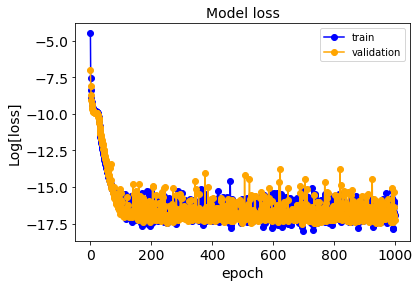

In [34]:
# plot losses

plt.figure()
plt.plot(np.log(history.history['loss']),'o-',color='blue')
plt.plot(np.log(history.history['val_loss']),'o-',color='orange')
plt.title('Model loss',fontsize=14)
plt.ylabel('Log[loss]',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['train', 'validation'])
plt.tick_params(labelsize=14)
#plt.savefig('model_log_loss.pdf')
plt.show()

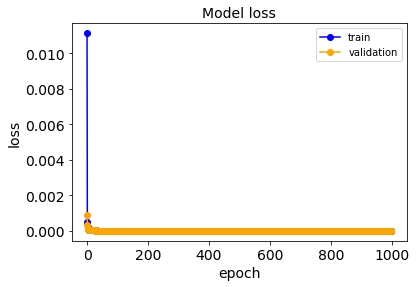

In [35]:
# plot losses

plt.figure()
plt.plot(history.history['loss'],'o-',color='blue')
plt.plot(history.history['val_loss'],'o-',color='orange')
plt.title('Model loss',fontsize=14)
plt.ylabel('loss',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['train', 'validation'])
plt.tick_params(labelsize=14)
#plt.savefig('model_loss.pdf')
plt.show()

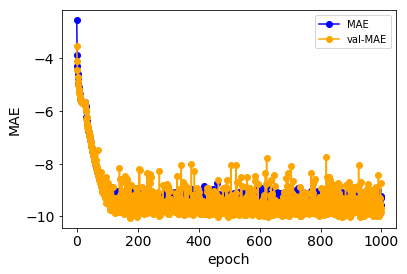

In [36]:
# plot losses

plt.figure()
plt.plot(np.log(history.history['mean_absolute_error']),'o-',color='blue',label='MAE')
plt.plot(np.log(history.history['val_mean_absolute_error']),'o-',color='orange',label='val-MAE')
#plt.title('Model loss',fontsize=14)
plt.ylabel('MAE',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend()
plt.tick_params(labelsize=14)
#plt.savefig('model_loss.pdf')
plt.show()

### Use model to make predictions on individual sequences

In [37]:
# predictions_on_test = model.predict(test_input_sequences_tensor)
predictions_on_test = model.predict([test_input_sequences_tensor,gamma_input_list[0:test_input_sequences_tensor.shape[0]]])

In [38]:
model.evaluate([test_input_sequences_tensor,gamma_input_list[0:test_input_sequences_tensor.shape[0]]],test_labels)

2000/2000 [==============================] - 0s 14us/step


[2.1547939853761022e-08, 5.070184470969252e-05]

In [39]:
np.shape(predictions_on_test)

(2000, 1)

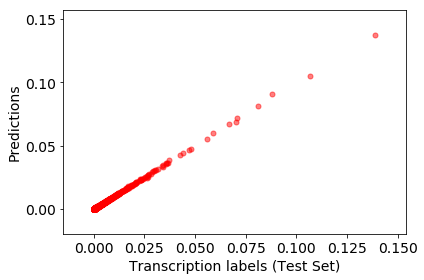

In [40]:
plt.scatter(test_labels,predictions_on_test,s=25,color="red",alpha=0.5)
plt.xlabel('Transcription labels (Test Set)',fontsize=14)
plt.ylabel('Predictions',fontsize=14)
plt.tick_params(labelsize=14)
#plt.plot([0,1])
#plt.xlim([0.3,0.5])
#plt.ylim([0.3,0.5])
plt.tight_layout()
#plt.savefig('write_up/Figures/Predictions_vs_labels.png')

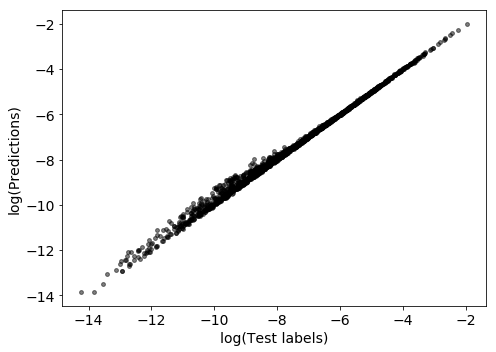

In [62]:
plt.figure(figsize=(7,5))
plt.scatter(np.log(test_labels),np.log(predictions_on_test),s=15,color="black",alpha=0.5)
plt.xlabel('log(Test labels)',fontsize=14)
plt.ylabel('log(Predictions)',fontsize=14)
plt.tick_params(labelsize=14)
plt.tight_layout()
#plt.savefig('../write_up/write_up_for_rnap_neural_network/log_predictions_vs_log_labels.png')
plt.show()
#plt.plot([0,1])

## Get intemediate layer activations

### Softmax activation

In [42]:
# layer 6 here corresponds to the softmax layer

# softmax_layer_model = Model(inputs=model.input,outputs=model.layers[7].output)
# softmax_output = softmax_layer_model.predict([test_input_sequences_tensor,gamma_input_list[0:test_input_sequences_tensor.shape[0]]])

# plt.figure(figsize=(7,5))
# plt.hist(softmax_output[:,0:1],bins=40,alpha=0.5,label='State 1')
# plt.hist(softmax_output[:,1:2],bins=40,alpha=0.5,label='State 2')
# plt.hist(softmax_output[:,2:3],bins=40,alpha=0.5,label='State 3')
# plt.hist(softmax_output[:,3:4],bins=40,alpha=0.5,label='State 4')
# plt.legend()
# plt.title("Histograms of values of softmax nodes",fontsize=14)
# plt.tick_params(labelsize=14)
# plt.show()

### First hidden layer activations $\epsilon_c$ and $\epsilon_r$ 

In [43]:
crp_node_model = Model(inputs=model.input,outputs=model.layers[3].output)
crp_node_activation = crp_node_model.predict([test_input_sequences_tensor,gamma_input_list[0:test_input_sequences_tensor.shape[0]]])

rnap_node_model = Model(inputs=model.input,outputs=model.layers[4].output)
rnap_node_activation = rnap_node_model.predict([test_input_sequences_tensor,gamma_input_list[0:test_input_sequences_tensor.shape[0]]])

# # mean normalization
# crp_node_activation_mean = np.mean(crp_node_activation)
# max_minus_min_crp_node = max(crp_node_activation)-min(crp_node_activation)

# rnap_node_activation_mean = np.mean(rnap_node_activation)
# max_minus_min_rnap_node = max(rnap_node_activation)-min(rnap_node_activation)

In [44]:
# mean normalization
# crp_node_activation = (crp_node_activation - crp_node_activation_mean)/(max_minus_min_crp_node)
# rnap_node_activation = (rnap_node_activation - rnap_node_activation_mean)/(max_minus_min_rnap_node)

In [45]:
test_e_c_list = e_c_list[training_data_size-test_data_size:training_data_size].copy()
test_e_r_list = e_r_list[training_data_size-test_data_size:training_data_size].copy()

# test_e_c_list_mean = np.mean(test_e_c_list)
# max_minus_min_test_e_c_list = max(test_e_c_list)-min(test_e_c_list)

# test_e_r_list_mean = np.mean(test_e_r_list)
# max_minus_min_test_e_r_list = max(test_e_r_list)-min(test_e_r_list)

In [46]:
# test_e_c_list = (test_e_c_list - test_e_c_list_mean)/(max_minus_min_test_e_c_list)
# test_e_r_list = (test_e_r_list - test_e_r_list_mean)/(max_minus_min_test_e_r_list)

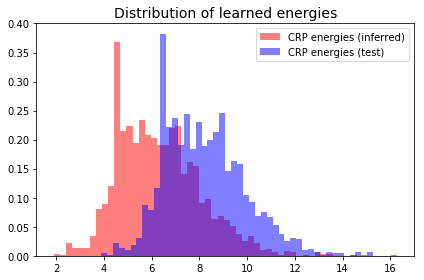

In [47]:
plt.hist(crp_node_activation,bins=50, label='CRP energies (inferred)',alpha=0.5,density=True,color='red')
plt.hist(np.array(test_e_c_list),bins=50, label='CRP energies (test)',alpha=0.5,density=True,color='blue')
plt.title('Distribution of learned energies',fontsize=14)
plt.legend()
plt.tight_layout()
#plt.savefig('learned_energies.pdf')
plt.show()

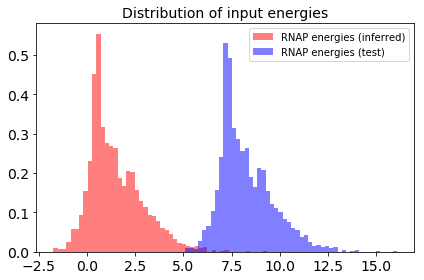

In [48]:
plt.hist(-rnap_node_activation,bins=50, label='RNAP energies (inferred)',alpha=0.5,density=True,color='red')
plt.hist(np.array(test_e_r_list),bins=50,alpha=0.5,label='RNAP energies (test)',density=True,color='blue')
plt.legend()
plt.tick_params(labelsize=14)
plt.title('Distribution of input energies',fontsize=14)
plt.tight_layout()
#plt.savefig('input_energies.pdf')
plt.show()

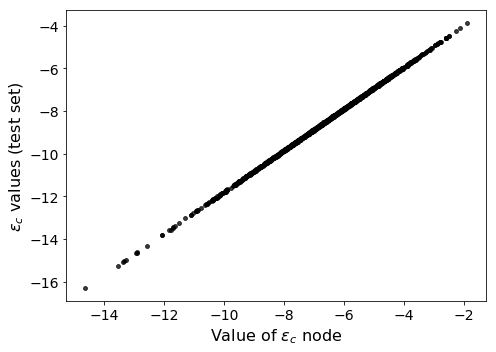

In [49]:
plt.figure(figsize=(7,5))
plt.scatter(-crp_node_activation,-np.array(test_e_c_list),color='black',s=15,alpha=0.75)
plt.tick_params(labelsize=14)
plt.ylabel(r'$\epsilon_c$'+' values (test set)',fontsize=16)
plt.xlabel('Value of '+r'$\epsilon_c$'+' node',fontsize=16)
plt.tight_layout()
#plt.savefig('comparison_e_crp_node_value_vs_test_e_c_list.png')
plt.show()

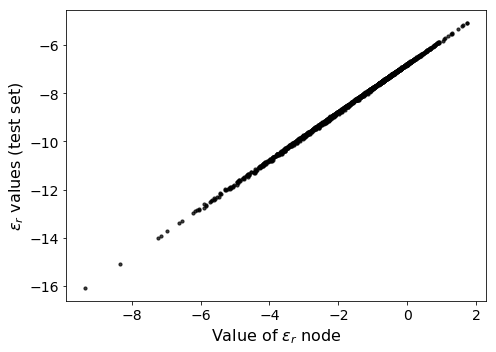

In [50]:
plt.figure(figsize=(7,5))
plt.scatter(rnap_node_activation,-np.array(test_e_r_list),color='black',s=10,alpha=0.75)
#plt.scatter(np.log(rnap_node_activation),-np.log(np.array(test_e_r_list)),color='black',s=10,alpha=0.75)
plt.tick_params(labelsize=14)
plt.ylabel(r'$\epsilon_r$'+' values (test set)',fontsize=16)
plt.xlabel('Value of '+r'$\epsilon_r$'+' node',fontsize=16)
plt.tight_layout()
#plt.savefig('write_up/Figures/comparison_e_rnap_node_value_vs_test_e_r_list.png')
plt.show()

### First hidden layer weights (PWMs)

Need to input sequence corresponding to CRPs binding site. i.e. fixed the shape of test_input_sequences_tensor

In [51]:
# crp_layer_model = Model(inputs=model.input,outputs=model.layers[3].output)
# # need to input sequence corresponding to CRPs binding site
# test_input_sequences_tensor[0].shape
# #crp_output = crp_layer_model.predict(test_input_sequences_tensor)

# # rnap_layer_model = Model(inputs=model.input,outputs=model.layers[4].output)
# # rnap_output = rnap_layer_model.predict(test_input_sequences_tensor)

# # print(crp_output.shape)
# # print(rnap_output.shape)

In [52]:
model.layers

In [53]:
crp_weights = model.layers[3].get_weights()[0].copy()
rnap_weights = model.layers[4].get_weights()[0].copy()

In [54]:
rnap_weights.shape

(164, 1)

## Get weights of first layer and compare to PWMs

These parameters will have to be gauge fixed

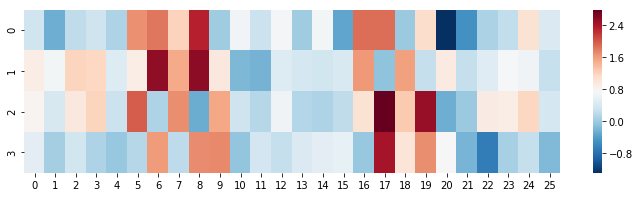

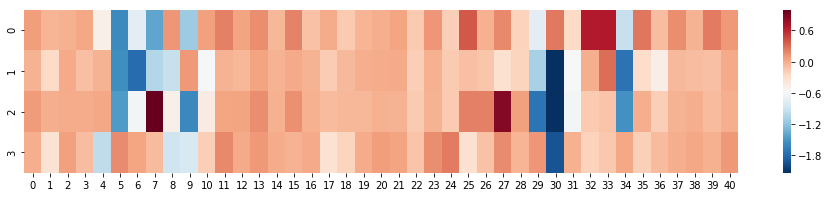

In [55]:
crp_weights = crp_weights.reshape(26,4)
rnap_weights = rnap_weights.reshape(41,4)


plt.figure(figsize=(12,3))
sns.heatmap(crp_weights.T,cmap='RdBu_r')
plt.show()
plt.figure(figsize=(16,3))
sns.heatmap(rnap_weights.T,cmap='RdBu_r')
#sns.heatmap(rnap_weights.T,cmap='RdBu_r')
plt.show()

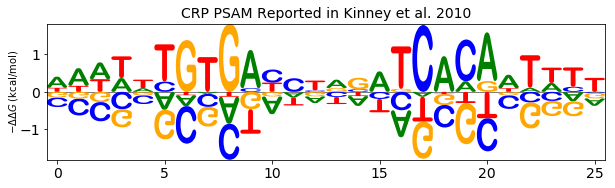

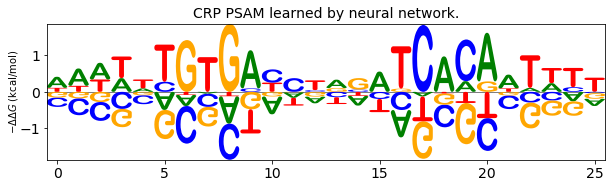

In [56]:
import logomaker
crp_logo_df = pd.DataFrame(crp_weights,columns=['A','C','G','T'])

crp_df.columns = ['A','C','G','T']
logomaker.Logo(-crp_df,center_values=True, font_name='Arial Rounded MT Bold')
plt.tick_params(labelsize=14)
plt.title('CRP PSAM Reported in Kinney et al. 2010',fontsize=14)
plt.ylabel("$-\Delta \Delta G$ (kcal/mol)", labelpad=-1)
logomaker.Logo(-crp_logo_df,center_values=True, font_name='Arial Rounded MT Bold')
plt.title('CRP PSAM learned by neural network.',fontsize=14)
plt.tick_params(labelsize=14)
plt.ylabel("$-\Delta \Delta G$ (kcal/mol)", labelpad=-1)

plt.show()
#logomaker.Logo(rnap_logo_df,center_values=True, font_name='Arial Rounded MT Bold')

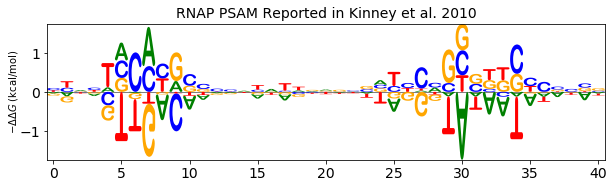

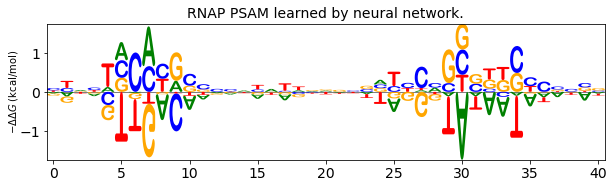

In [57]:
rnap_logo_df = pd.DataFrame(rnap_weights,columns=['A','C','G','T'])
rnap_df.columns = ['A','C','G','T']
logomaker.Logo(rnap_df,center_values=True, font_name='Arial Rounded MT Bold')
plt.tick_params(labelsize=14)
plt.title('RNAP PSAM Reported in Kinney et al. 2010',fontsize=14)
plt.ylabel("$-\Delta \Delta G$ (kcal/mol)", labelpad=-1)
logomaker.Logo(-rnap_logo_df,center_values=True, font_name='Arial Rounded MT Bold')
plt.tick_params(labelsize=14)
plt.title('RNAP PSAM learned by neural network.',fontsize=14)
plt.ylabel("$-\Delta \Delta G$ (kcal/mol)", labelpad=-1)
plt.tick_params(labelsize=14)

In [58]:
len(rnap_logo_df.loc[0:])

41

### Verify that weights have stayed unchanged after training:

In [59]:
model.layers[7].get_weights()[0]

array([[0., 1., 0., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [60]:
#model.save_weights('Neural_Network_Thermodynamic_Model_double_branch.h5')

### Learned weights of last layer

In [61]:
model.layers[8].get_weights()

[array([[0.        ],
        [0.        ],
        [1.2932755 ],
        [0.00558769]], dtype=float32)]